<font size='10'><h1 align="center"><font color='blue'>iPy oxDNA Examples</font></h1>

<center>
<img src="oxDNA.png">
</center>

<font size='10'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Duplex Melting</font></h2> 

In [1]:
from ipy_oxdna.umbrella_sampling import MeltingUmbrellaSampling
from ipy_oxdna.oxdna_simulation import SimulationManager, Simulation, Observable
from ipy_oxdna.vmmc import *

import os
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

<font size='10'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Potential Energy Umbrella Temperature Interpolation</font></h2> 

In [2]:
path = os.path.abspath('/scratch/mlsample/ipy_oxDNA/ipy_oxdna_examples/duplex_melting/')

system_name = 'external_force_file'

conditions = ['5']

systems = [f'duplex_52_{stiff}' for stiff in conditions]

file_dirs = [f'{path}/{system_name}' for _ in range(len(systems))]


xmin = 0
xmax = 15
n_windows = 100
starting_r0 = 0.4213
stiff = 5
print_every = 1e4
temperature = '52C'
name = 'all_observables.txt'

pre_eq_steps = 5e6
eq_steps = 1e8
prod_steps = 1e9

verlet_skin = 0.5

hb_contact_filename = 'hb_contacts.txt'

com_list = ','.join('8,9,10,11,12,13,14,15'.split(',')[::-1])
ref_list = '0,1,2,3,4,5,6,7'

particle_indexes = [com_list, ref_list]
hb_contact_observable = [{'idx':particle_indexes, 'name':f'{hb_contact_filename}', 'print_every':int(print_every)}]


pre_equlibration_parameters_list = [{'backend':'CPU',"CUDA_list": "no",'use_edge': 'false','steps':f'{pre_eq_steps}','print_energy_every': f'{pre_eq_steps}',
                           'print_conf_interval':f'{pre_eq_steps}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}' }
                            for _ in conditions]

equlibration_parameters_list = [{'backend':'CPU',"CUDA_list": "no",'use_edge': 'false','steps':f'{eq_steps}','print_energy_every': f'{eq_steps}',
                           'print_conf_interval':f'{eq_steps/10}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}'}
                            for _ in conditions]

production_parameters_list = [{'backend':'CPU',"CUDA_list": "no",'use_edge': 'false','steps':f'{prod_steps}','print_energy_every': f'{prod_steps}',
                           'print_conf_interval':f'{prod_steps/10}', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'T':f'{temperature}', 'verlet_skin': f'{verlet_skin}'}
                            for _ in conditions]

us_list = [MeltingUmbrellaSampling(file_dir, sys, clean_build='force') for file_dir, sys in zip(file_dirs,systems)]
simulation_manager = SimulationManager()

In [5]:
for us, pre_equlibration_parameters in zip(us_list, pre_equlibration_parameters_list):
    print(us.system)
    us.build_pre_equlibration_runs(simulation_manager, n_windows, com_list, ref_list,
                               stiff, xmin, xmax, pre_equlibration_parameters, starting_r0, pre_eq_steps,
                               print_every=print_every, observable=True, protein=None,
                               force_file=True, continue_run=False, name=name, custom_observable=hb_contact_observable)

duplex_52_5


In [ ]:
simulation_manager.worker_manager(cpu_run=True, gpu_mem_block=False)

In [7]:
for us, equlibration_parameters in zip(us_list, equlibration_parameters_list):
    print(us.system)
    us.build_equlibration_runs(simulation_manager, n_windows, com_list, ref_list,
                               stiff, xmin, xmax, equlibration_parameters, print_every=print_every,
                               observable=True, protein=None, force_file=True, continue_run=False, name=name, custom_observable=hb_contact_observable)

duplex_52_5


In [ ]:
simulation_manager.run(cpu_run=True, gpu_mem_block=False)

In [20]:
for us, production_parameters in zip(us_list, production_parameters_list):
    print(us.system)
    us.build_production_runs(simulation_manager, n_windows, com_list, ref_list,
                             stiff, xmin, xmax, production_parameters,
                             observable=True, print_every=print_every ,protein=None,
                             force_file=True, continue_run=False, name=name, custom_observable=hb_contact_observable)

duplex_52_5


In [ ]:
simulation_manager.run(cpu_run=True, gpu_mem_block=False)

In [ ]:
simulation_manager.terminate_all()

In [3]:
for us in us_list:
    us.observables_list = []
    us.com_distance_observable(com_list, ref_list, print_every=print_every, name=name)
    us.hb_list_observable(print_every=print_every, only_count='true', name=name)
    us.force_energy_observable(print_every=print_every, name=name)
    us.kinetic_energy_observable(print_every=print_every, name=name)
    us.potential_energy_observable(print_every=print_every, name=name)

all_observables = []
for us in us_list:
    all_observables.append(us.analysis.read_all_observables('prod'))

/scratch/mlsample/ipy_oxDNA/ipy_oxdna/oxdna_simulation.py:1509: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(self.sim_files.energy, delimiter="\s+",names=['time', 'U','P','K'])


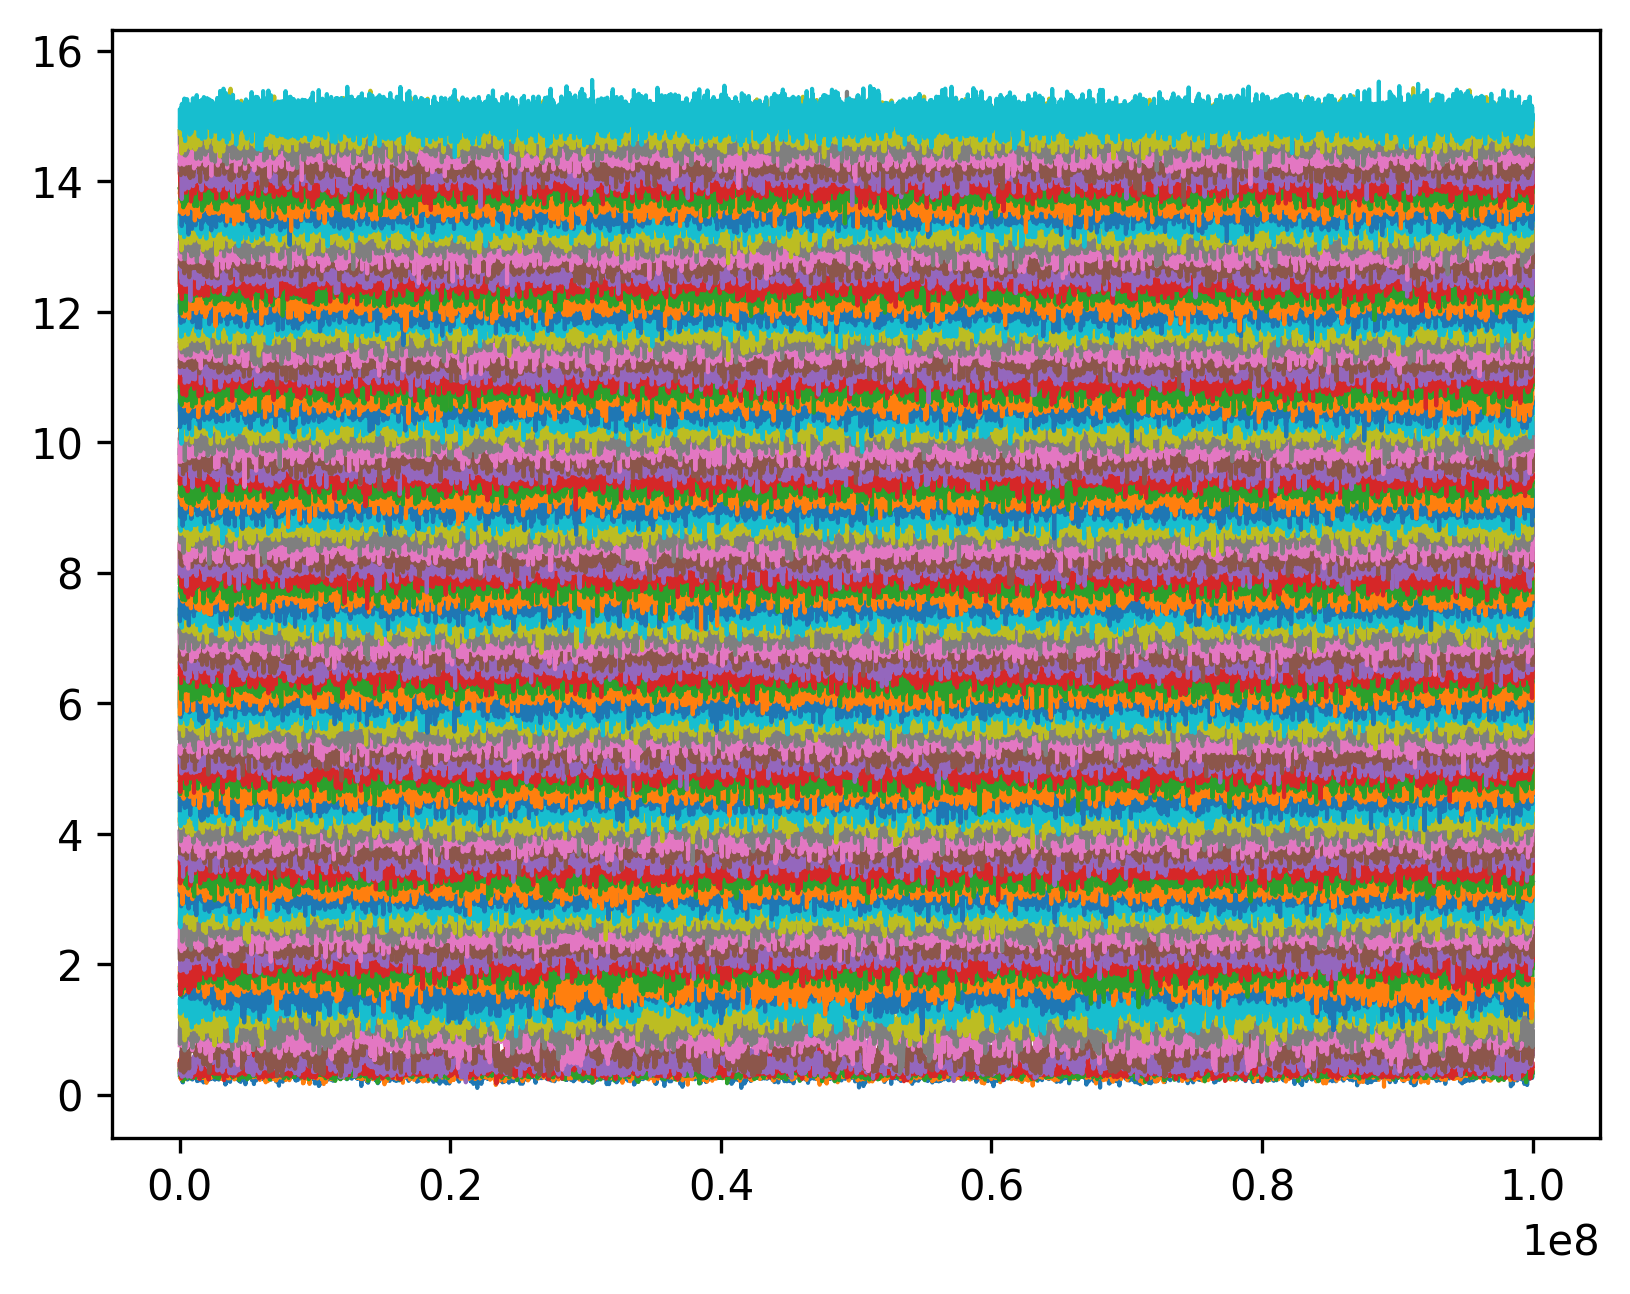

In [5]:
names = ['backbone', 'bonded_excluded_volume', 'stacking', 'nonbonded_excluded_volume', 'hydrogen_bonding', 'cross_stacking', 'coaxial_stacking', 'debye_huckel']
columns = ['com_distance', 'hb_list', 'force_energy', *names]

my_obs = all_observables[0]

fig, ax = plt.subplots(dpi=300)
for idx, obs in enumerate(my_obs):
    plt.plot(obs['steps'], obs['com_distance'].rolling(window=1).mean(), label=f'{idx}', linewidth=1)
# plt.legend(fontsize=1)

(-0.05, 1.05)

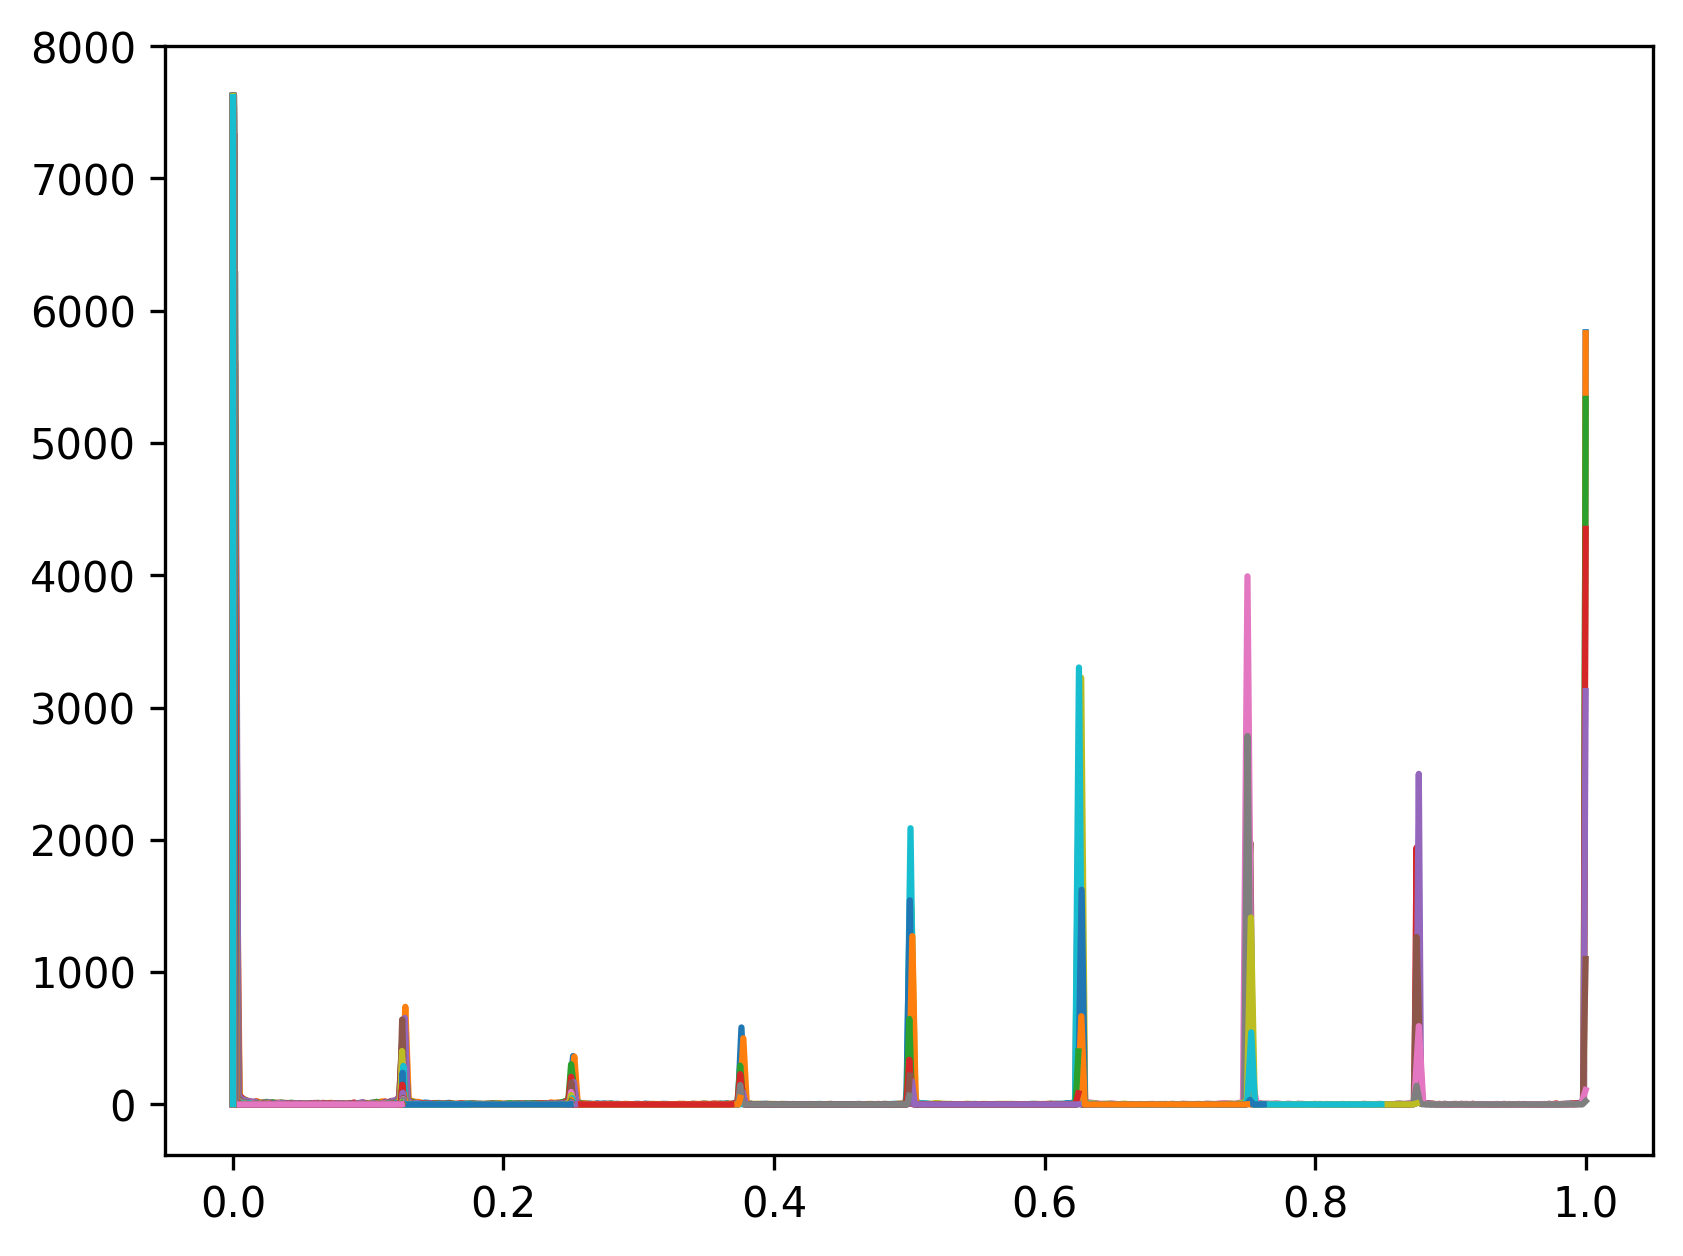

In [13]:
us_list[0].read_hb_contacts(sim_type='eq')

min_len = min([len(inner_list) for inner_list in us_list[0].hb_contacts_by_window.values()])
truncated_hb_contacts_by_window = np.array([value[:min_len] for value in us_list[0].hb_contacts_by_window.values()]).squeeze()

fig, ax = plt.subplots(dpi=300)
for hb_contacts in truncated_hb_contacts_by_window:
    
    H, bins = np.histogram(hb_contacts, bins=300)
    ax.plot(bins[1:], H)
ax.set_xlim(-0.05, 1.05)

In [ ]:
for sim in us_list[0].pre_equlibration_sims[::5]:
    sim.analysis.view_last()

In [90]:
xmin = 0
xmax = 15
# temp_range = np.linspace(45, 65, 41)
temp_range = np.array([52])
# temp_range = np.array([20, 30, 40, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 70, 80])
n_bins = 200
max_hb = 8
epsilon = 1e-6
convergence_slice = 1

us_list[0].wham_cont_and_disc_temp_interp_converg_analysis(convergence_slice, temp_range,
                                                           n_bins, xmin, xmax,max_hb,
                                                           epsilon=epsilon, reread_files=False,
                                                           all_observables=True)

WHAM | 10000/? [00:07<00:00, 1349.70it/s, Convergence: 0.0000014 / 1e-06]
/scratch/mlsample/ipy_oxDNA/ipy_oxdna/umbrella_sampling.py:1332: RuntimeWarning: divide by zero encountered in log
  free = -np.log(p_x)


Converged in [10351] iterations
52.0


/home/mlsample/.local/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


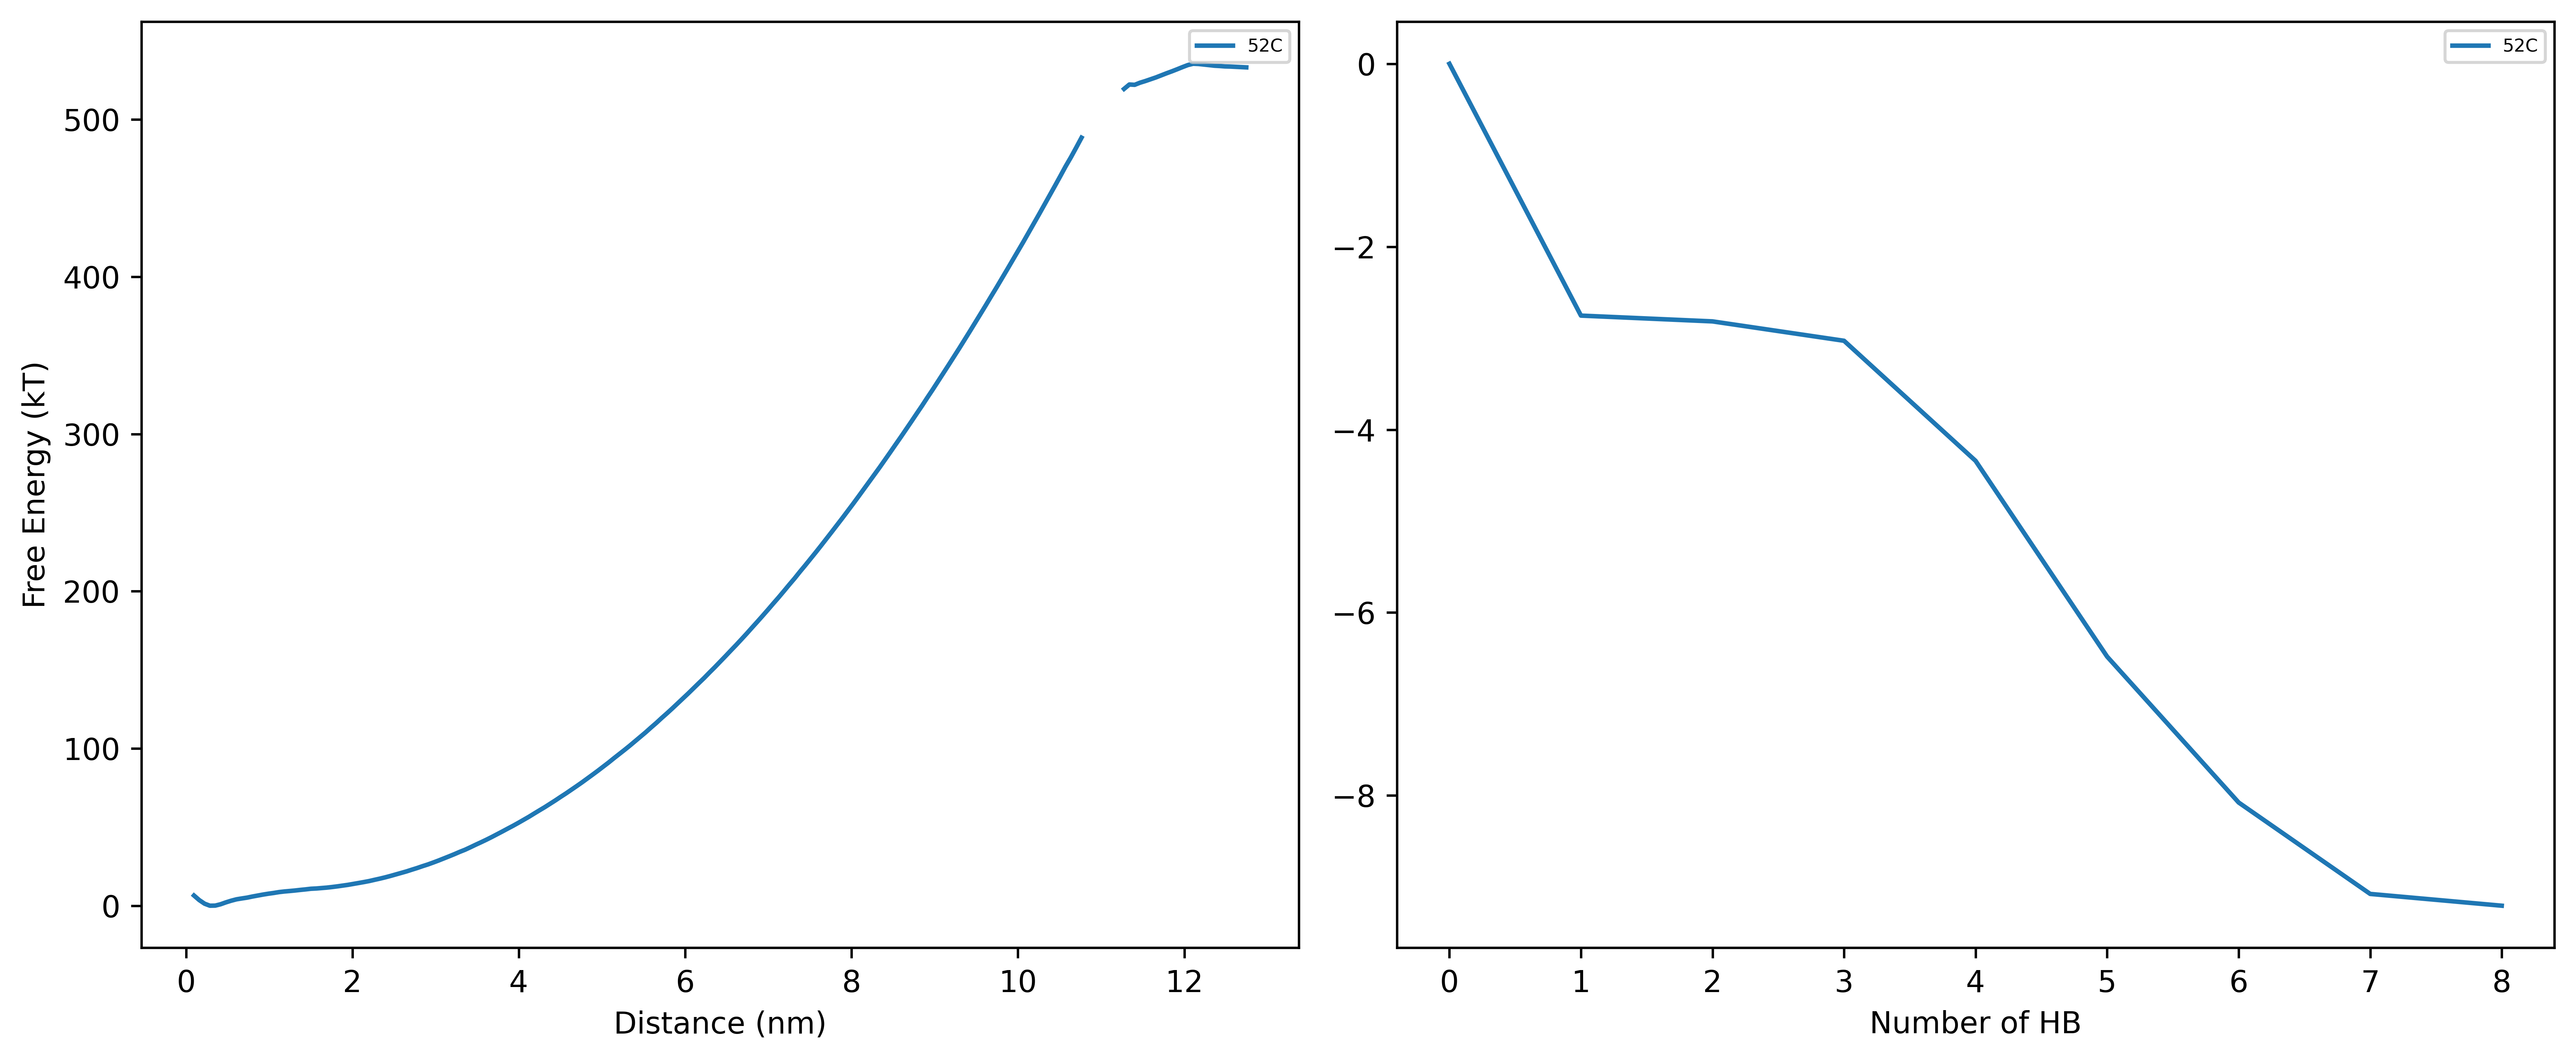

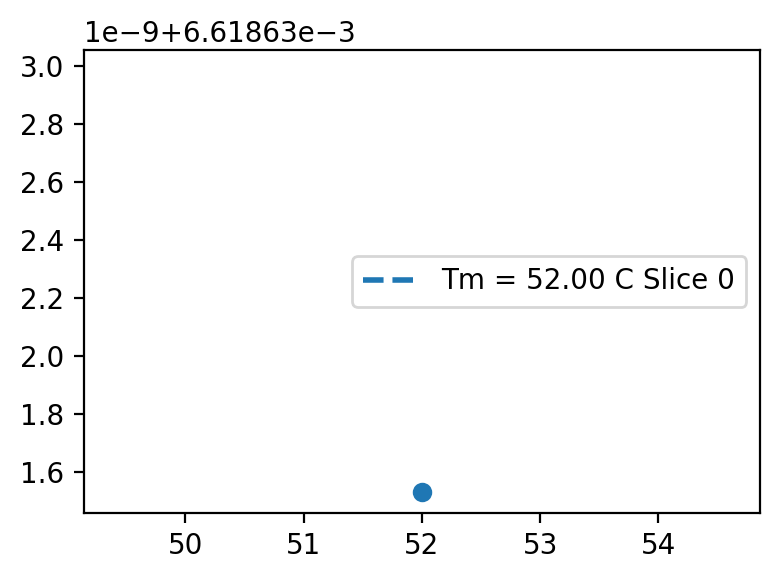

In [91]:
calculated_bin_centers, bin_edges = us_list[0].get_bins(xmin, xmax, n_bins=n_bins)

fig, (ax1, ax2) = plt.subplots(1,2, dpi=600, figsize=(12,5), tight_layout=True)
fig, ax = plt.subplots(dpi=200, figsize=(4,3), tight_layout=True)

ax1.set_xlabel('Distance (nm)')
ax2.set_xlabel('Number of HB')

ax1.set_ylabel('Free Energy (kT)')
# ax2.set_ylabel('Free Energy (kT)')

# ax1.set_xlim(-0.6,14.5)
# ax2.set_xlim(-0.6,29)
# ax1.set_ylim(-0.6,20)

for idx, free in enumerate(us_list[0].convergence_free):            
    sub_index = free[0].argmin()
    for f, temp_val in zip(free, temp_range):
        if idx == 0:
            ax1.plot(calculated_bin_centers*0.8518, f - f[sub_index], label=f'{temp_val}C') 
        else:
            ax1.plot(calculated_bin_centers*0.8518, f - f[sub_index])
        
ax1.legend(fontsize=6)


for idx, free_discrete in enumerate(us_list[0].convergence_discrete_free_energy):
    for f_discrete, temp_val in zip(free_discrete, temp_range):
        if idx == 0:
            ax2.plot(range(max_hb+1), f_discrete - f_discrete[0], label=f'{temp_val}C')
        else:
            ax2.plot(range(max_hb+1), f_discrete - f_discrete[0])
ax2.legend(fontsize=6)

label = ''

for idx, (inverted_finfs, x_fit, y_fit, Tm) in enumerate(zip(us_list[0].convergence_inverted_finfs, us_list[0].convergence_x_fit, us_list[0].convergence_y_fit, us_list[0].convergence_Tm)):
    ax.scatter(temp_range, inverted_finfs, marker='o')
    ax.plot(x_fit, y_fit, linestyle='--', linewidth=2, label=f'Tm = {Tm:.2f} C Slice {idx}')
    # ax.axvline(x=Tm, color='r', linestyle='--', linewidth=2, label=f'{label}Tm = {Tm:.2f} °C')
    ax.legend()   

In [92]:
wham_dir = os.path.abspath('/scratch/mlsample/ipy_oxDNA/wham/wham')
n_bins = '400'
tol = '1e-5'
n_boot = '0'


xmin = [0]
xmax = [15]
n_windows = 100
stiff = 5
print_every = 1e4
temperature = '52C'
name = 'all_observables.txt'

pre_eq_steps = 1e6
eq_steps = 1e8
prod_steps = 1e9

for us in us_list:
    us.observables_list = []
    us.com_distance_observable(com_list, ref_list, print_every=print_every, name=name)
    us.hb_list_observable(print_every=print_every, only_count='true', name=name)
    us.force_energy_observable(print_every=print_every, name=name)
    us.potential_energy_observable(print_every=print_every, name=name)

for us, xmi, xma  in zip(us_list, xmin, xmax):
    us.wham_run(wham_dir, xmi, xma, stiff, n_bins, tol, n_boot, all_observables=True)
    
n_chunks = 2
data_added_per_iteration = 2

for us, xmi, xma  in zip(us_list, xmin, xmax):
    us.wham.get_n_data_per_com_file()
    us.convergence_analysis(n_chunks, data_added_per_iteration, wham_dir, xmi, xma, stiff, n_bins, tol, n_boot)

Running WHAM analysis...
WHAM analysis completed
[0, 4889, 9778]
Running WHAM analysis...


ValueError: could not convert string to float: '[0]'

In [ ]:
for us in us_list:
    us.wham.plot_truncated_free_energy()
    plt.legend()
    plt.title(us.system)
    us.wham.plot_chunks_free_energy()
    plt.legend()
    plt.title(us.system)

<font size='7'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Initalize Vmmc Replicas</font></h2> 

In [ ]:
path = os.path.abspath('/scratch/mlsample/ipy_oxDNA/ipy_oxdna_examples')
systems = ['duplex_melting']

file_dir_list = [f'{path}/{sys}' for sys in systems]
sim_dir_list = [f'{file_dir}/vmmc_melting_replicas/vmmc_melting_rep' for sys, file_dir in zip(systems, file_dir_list)]

n_replicas = 40
vmmc_replica_generator = VmmcReplicas()

vmmc_replica_generator.multisystem_replica(
    systems,
    n_replicas,
    file_dir_list,
    sim_dir_list
)
vmmc_sim_list = vmmc_replica_generator.sim_list
queue_of_simulations = vmmc_replica_generator.queue_of_sims

p1 = '15,14,13,12,11,10,9,8'
p2 = '0,1,2,3,4,5,6,7'
pre_defined_weights = [8, 16204, 1882.94, 359.746, 52.5898, 15.0591, 7.21252, 2.2498, 2.89783]

sim_parameters = {'T':'52C', 'steps':'1e9','print_energy_every': '1e5','print_conf_interval':'1e6'}

In [ ]:
vmmc_sim_list[0].analysis.read_vmmc_op_data()
vmmc_sim_list[0].analysis.calculate_sampling_and_probabilities()

In [ ]:
with plt.style.context(['science', 'no-latex', 'bright']):
    ax = us.wham.plt_fig() 
    vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax, confidence_level=0.95, label='VMMC discrete made continuous 52C')
    # us_1.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuous umbrella sampling 52C all bonds')
    us.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuos umbrella sampling 52C only intended bonds')
    ax.set_xlim(-0.1,8)
    plt.ylim(-0.1,9)
plt.legend(fontsize=6)

In [ ]:
with plt.style.context(['science', 'no-latex', 'bright']):
    ax = us.wham.plt_fig() 
    # vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=500, ax=ax, confidence_level=0.95, label='VMMC discrete made continuous 52C')
    us_1.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuous umbrella sampling 52C all bonds')
    us.wham.plot_free_energy(confidence_level=0.99, ax=ax, errorevery=10, label='Continuos umbrella sampling 52C only intended bonds')
    # ax.set_xlim(-0.1,8)
    # plt.ylim(-0.1,9)
plt.legend(fontsize=6)